## Fig 4. Weak periodic drive evokes replay-like transient sequences with intra-ripple frequency accommodation (IFA).

### A.
mean firing rate, membrane potentialの変化. input currentもいれる. これがsimulation, FREで一致することを見る.

### B.
sequential activity predicted by FREs.

### C.
sequential activity exhibited in the numerical simulation.

### D.
transient response exhibits IFA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root
from scipy.linalg import eig
from scipy.interpolate import interp1d
import pywt
import os
from QIFNetwork import *
from FREs import *


In [ ]:
# config for plotting.
config = {
        'font.family' : 'sans-serif',
        'font.size' : 12.0,
        'xtick.direction' : 'in',
        'ytick.direction' : 'in',
        'axes.xmargin' : 0.1,
        'axes.ymargin' : 0.11,
        'axes.linewidth' : 1.0,
        'axes.titlelocation' : 'left',
        'lines.linewidth' : 0.7,
        'legend.fancybox' : False,
        'legend.loc' : 'upper right'
    }
plt.rcParams.update(config)
# label = ['(' + chr(ord("a")+i) + ')' for i in range(26)]
savedir = 'fig4/'
os.makedirs(savedir, exist_ok=True)

In [3]:
# parameters
J1 = 1.8; J2 = 15; eta = -5; delta = 1.0
P = 10

In [4]:
t0 = 0; t1 = 100
t_eval = np.linspace(t0, t1, 10000)

# compute fixed points
focus = root(lambda y : fre_single(0, y, J2, eta, delta), [[1, 0]]).x
node = root(lambda y : fre_single(0, y, J2, eta, delta), [[0, -2]]).x
saddle = root(lambda y : fre_single(0, y, J2, eta, delta), [[0.5, -0.5]]).x

In [5]:
# define external input and parameters
i_amp = 2.0
i_period = 40.0
i_omega = np.pi * 2 / i_period
i_ext_current = lambda t: i_amp * np.sin(i_omega * t) * (t > 0)

# define impulse input and parameters
i_impulse_amp = 2.0
t_first_impulse = 0.2 * i_period
jump = lambda y: y + i_impulse_amp * np.eye(2*P)[P]

y0 = np.repeat(node, P)
t0 = -10; t1 = i_period * 2; 
t_eval = np.linspace(t0, t1, 20000)
impulse_times = np.arange(t_first_impulse, t1 + 1e-9, i_period)

t_sol = [t0]
y_sol = [y0]

t_prev = t0
y_prev = copy.deepcopy(y0)
for t_impulse in np.append(impulse_times, t1):
    # solve the system before the impulse
    t_eval_this_period = t_eval[(t_eval >= t_prev) & (t_eval < t_impulse)]
    sol = solve_ivp(fre_seq, (t_prev, t_impulse), y_prev, args=(J1, J2, eta, delta, P, i_ext_current), t_eval=t_eval_this_period, method="RK45", rtol=1e-10, atol=1e-10)
    # concatenate the results (except the first point)
    t_sol.extend(sol.t[1:])
    y_sol.extend(sol.y.T[1:])

    y_prev = jump(y_sol[-1])
    t_prev = t_impulse

t_sol = np.array(t_sol)
y_sol = np.array(y_sol)

r_mean = y_sol[:, :P].mean(axis=1)     # shape = (len(t_sol),)
v_mean = y_sol[:, P:].mean(axis=1)     # shape = (len(t_sol),)


B: predicted activity, D: IFA の図はこの時点で作れる.
A: FRE vs simulation, C: simulation の結果はQIFnetworkのsimulationが必要.

Representative episodes of sharp-wave ripples. In the later panel, we compare the results with numerical simulations.


/tmp/ipykernel_1403397/842774154.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


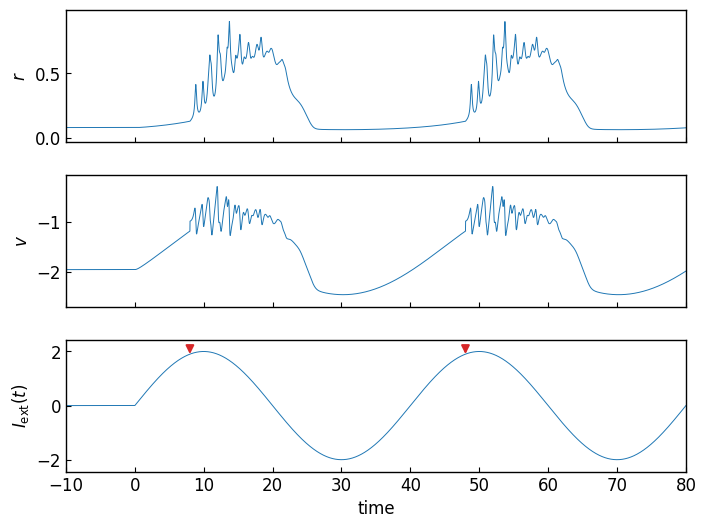

Firing rate of each group (offset stack)


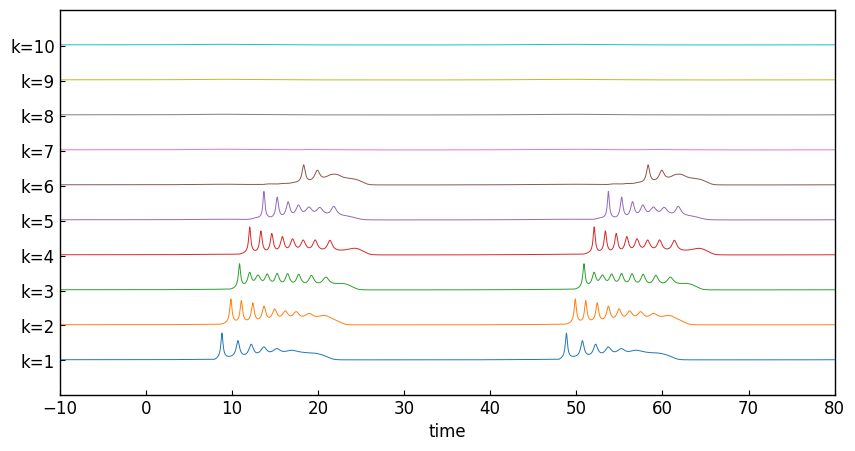

In [6]:
print("Representative episodes of sharp-wave ripples. In the later panel, we compare the results with numerical simulations.")
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, gridspec_kw={'hspace': 0.25})

axes[0].plot(t_sol, r_mean)
axes[0].set_ylabel(r'$r$')
axes[1].plot(t_sol, v_mean)
axes[1].set_ylabel(r'$v$')
axes[2].plot(t_sol, i_ext_current(t_sol))
axes[2].set_ylabel(r"$I_{\mathrm{ext}}(t)$")
axes[2].set_xlabel("time")
axes[2].set_xlim(t0, t1)
offset = 0.15 * i_amp          # y 軸方向のオフセット量（調整可）
for t_imp in impulse_times:
    y_tip = i_ext_current(t_imp)             # 正弦波上の値
    axes[2].annotate("",
        xy=(t_imp, y_tip),                   # 先端
        xytext=(t_imp, y_tip + offset),      # 出発点
        arrowprops=dict(arrowstyle="-|>",    # 下向きヘッド
                        lw=1.5, color="C3",
                        shrinkA=0, shrinkB=0))
plt.tight_layout()
plt.show()

print('Firing rate of each group (offset stack)')
r_sol = y_sol[:, :P]
fig, ax = plt.subplots(figsize=(10, 5))
offset = r_sol.max() * 1.2          # 行間
for k in range(P):
    ax.plot(t_sol, r_sol[:, k] + k*offset)
ax.set_xlabel('time')
ax.set_xlim(t0, t1)
ax.set_yticks(offset*np.arange(P))
ax.set_yticklabels([f'k={k+1}' for k in range(P)])
# plt.savefig(savedir + 'replay_fres.pdf', bbox_inches='tight')
plt.show()

# plt.imshow(y_sol[:, :P].T, aspect='auto', extent=[t0, t1, 0, P], vmax = 3, vmin = 0,origin='lower', interpolation='none')
# plt.colorbar(label='Firing rate')
# plt.xlabel('Time')
# plt.ylabel('Population index')
# plt.title('Firing rate of each population')
# plt.tight_layout()
# plt.show();

# t_cond = np.logical_and(t_sol > 0, t_sol < i_period)
# plt.imshow(y_sol[t_cond, :P].T, aspect='auto', extent=[0, i_period, 0, P], vmax = 3, vmin = 0,origin='lower', interpolation='none')
# plt.colorbar(label='Firing rate')
# plt.xlabel('Time')
# plt.ylabel('Population index')
# plt.show()

# for p in range(0, 5):
#     cond = np.logical_and(t_sol > 0, t_sol < i_period)
#     plt.plot(t_sol[cond], y_sol[cond, p], label=f'Population {p+1}')
# plt.xlabel('Time')
# plt.ylabel('Firing rate')
# plt.title('Firing rate of each population (detailed view)')
# plt.legend()
# plt.tight_layout()
# plt.show()



Fig. D  
- spectrogramを図示して, IFAの存在を確認する.

scalogram of r_mean.


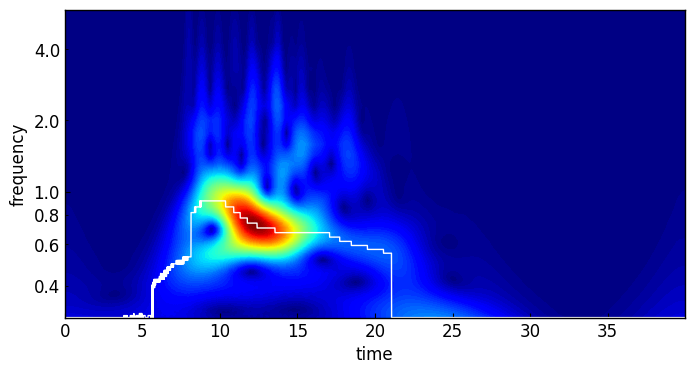

In [7]:
import matplotlib.ticker as mticker
# spectogram用にはもう少し何回かの平均を取る.

# define external input and parameters
i_amp = 2.0
i_period = 40.0
i_omega = np.pi * 2 / i_period
i_ext_current = lambda t: i_amp * np.sin(i_omega * t) * (t > 0)

# define impulse input and parameters
i_impulse_amp = 2.0
t_first_impulse = 0.2 * i_period
jump = lambda y: y + i_impulse_amp * np.eye(2*P)[P]

y0 = np.repeat(node, P)
t0 = -10; t1 = i_period * 4; 
t_eval = np.linspace(t0, t1, 20000)
impulse_times = np.arange(t_first_impulse, t1 + 1e-9, i_period)

t_sol = [t0]
y_sol = [y0]

t_prev = t0
y_prev = copy.deepcopy(y0)
for t_impulse in np.append(impulse_times, t1):
    # solve the system before the impulse
    t_eval_this_period = t_eval[(t_eval >= t_prev) & (t_eval < t_impulse)]
    sol = solve_ivp(fre_seq, (t_prev, t_impulse), y_prev, args=(J1, J2, eta, delta, P, i_ext_current), t_eval=t_eval_this_period, method="RK45", rtol=1e-10, atol=1e-10)
    # concatenate the results (except the first point)
    t_sol.extend(sol.t[1:])
    y_sol.extend(sol.y.T[1:])

    y_prev = jump(y_sol[-1])
    t_prev = t_impulse

t_sol = np.array(t_sol)
y_sol = np.array(y_sol)

r_mean = y_sol[:, :P].mean(axis=1)     # shape = (len(t_sol),)
v_mean = y_sol[:, P:].mean(axis=1)     # shape = (len(t_sol),)

# ---------------------------------------------------------------------
# 1. エピソード平均膜電位の計算
# ---------------------------------------------------------------------
# t_sol, v_mean, i_period, t1 が既に定義されている前提
num_episodes = int(t1 // i_period)

episode_masks = [
    (t_sol > i_period * k) & (t_sol < i_period * (k + 1))
    for k in range(num_episodes)
]

min_len = min(mask.sum() for mask in episode_masks)
v_stack = np.stack([v_mean[mask][:min_len] for mask in episode_masks])
v_mean_allep = v_stack.mean(axis=0)             # shape = (min_len,)

# ---------------------------------------------------------------------
# 2. 対称パディング → CWT
# ---------------------------------------------------------------------
dt     = t_sol[1] - t_sol[0]
scales = np.linspace(20, 400, 50)

pad_width  = len(v_mean_allep) // 2             # 前後に半周期ずつ足す例
v_padded   = pywt.pad(v_mean_allep, pad_width, mode='symmetric')

coef_padded, freqs = pywt.cwt(
    v_padded,
    scales,
    wavelet='cmor1.5-1.0',
    sampling_period=dt,
    method='fft'
)

# パディング分を切り取る
coef = coef_padded[:, pad_width:-pad_width]

# # ---------------------------------------------------------------------
# # 3'. 「ピーク電力が十分大きい時だけ」プロットするためのマスク
# # ---------------------------------------------------------------------
# peak_power = power[peak_idx, np.arange(power.shape[1])]  # 時間軸ごとの最大パワー
# thresh_db  = -25                                         # 例: −40 dB 未満は無視
# mask_good  = 10 * np.log10(peak_power / peak_power.max()) > thresh_db

# # ---------------------------------------------------------------------
# # 4. 可視化（ピーク周波数は有効点だけ白線で描画）
# # ---------------------------------------------------------------------
# time_axis = np.arange(len(v_mean_allep)) * dt

# print("scalogram of r_mean.")
# plt.figure(figsize=(8, 4))
# plt.contourf(time_axis, freqs, np.abs(coef), 100, cmap='jet')
# plt.yscale('log')
# plt.xlabel('Time [s]')
# plt.ylabel('Frequency [Hz]')

# # 有効ビンのみ描画（無効ビンは NaN で飛ばす）
# peak_freq_masked = np.where(mask_good, peak_freq, np.nan)
# plt.plot(time_axis, peak_freq_masked, color='w', linewidth=2, label='Peak freq')

# plt.legend()
# plt.tight_layout()
# plt.show()

# ---------------------------------------------------------------------
# 3. ピーク周波数の抽出
# ---------------------------------------------------------------------
power      = np.abs(coef)**2
peak_idx   = power.argmax(axis=0)
peak_freq  = freqs[peak_idx]


# ---------------------------------------------------------------------
# 4. 可視化
# ---------------------------------------------------------------------
time_axis = np.arange(len(v_mean_allep)) * dt
print("scalogram of r_mean.")
fig, ax = plt.subplots(figsize=(8, 4))
ax.contourf(time_axis, freqs, np.abs(coef), 100, cmap='jet')
# ピーク周波数（白線）
ax.plot(time_axis, peak_freq, color='w', linewidth=1)
ax.set_xlabel('time')
ax.set_ylabel('frequency')
ax.set_yscale('log')

# major：1, 10, 100 …
ax.yaxis.set_major_locator(mticker.LogLocator(base=10))
ax.yaxis.set_major_formatter(mticker.LogFormatter(base=10))

# minor：0.2, 0.4, 0.6, 0.8, 2, 4, 6, 8 …
ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=(2, 4, 6, 8)))

# minor もラベルを付ける（minor_thresholds=(∞,∞) で "全部表示" 強制）
ax.yaxis.set_minor_formatter(
    mticker.LogFormatter(base=10, labelOnlyBase=False,
                         minor_thresholds=(float('inf'), float('inf')))
)
from matplotlib.ticker import FuncFormatter

fmt = FuncFormatter(lambda y, _: f'{y:.1f}')
ax.yaxis.set_major_formatter(fmt)
ax.yaxis.set_minor_formatter(fmt)
# 見づらければ minor の文字サイズを下げる
# ax.tick_params(which='minor', labelsize=8)
plt.savefig(savedir + "spectrogram.pdf", bbox_inches='tight') 
plt.show()


In [8]:
# define external input and parameters
i_amp = 2.0
i_period = 40.0
i_omega = np.pi * 2 / i_period
i_ext_current = lambda t: i_amp * np.sin(i_omega * t) * (t > 0)

# define impulse input and parameters
i_impulse_amp = 2.0
t_first_impulse = 0.2 * i_period
jump = lambda y: y + i_impulse_amp * np.eye(2*P)[P]

y0 = np.repeat(node, P)
t0 = -10; t1 = i_period * 2; 
t_eval = np.linspace(t0, t1, 20000)
impulse_times = np.arange(t_first_impulse, t1 + 1e-9, i_period)

t_sol = [t0]
y_sol = [y0]

t_prev = t0
y_prev = copy.deepcopy(y0)
for t_impulse in np.append(impulse_times, t1):
    # solve the system before the impulse
    t_eval_this_period = t_eval[(t_eval >= t_prev) & (t_eval < t_impulse)]
    sol = solve_ivp(fre_seq, (t_prev, t_impulse), y_prev, args=(J1, J2, eta, delta, P, i_ext_current), t_eval=t_eval_this_period, method="RK45", rtol=1e-10, atol=1e-10)
    # concatenate the results (except the first point)
    t_sol.extend(sol.t[1:])
    y_sol.extend(sol.y.T[1:])

    y_prev = jump(y_sol[-1])
    t_prev = t_impulse

t_sol = np.array(t_sol)
y_sol = np.array(y_sol)
r_sol = y_sol[:, :P]
v_sol = y_sol[:, P:]
r_mean = r_sol.mean(axis=1)     # shape = (len(t_sol),)
v_mean = v_sol.mean(axis=1)     # shape = (len(t_sol),)


network simulationをする.

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
params = {'syn_delay' : 1e-8,
          'vmin' : -100,
          'vmax' : 100,
          'device' : device}
print(params)

{'syn_delay': 1e-08, 'vmin': -100, 'vmax': 100, 'device': 'cuda'}


In [19]:
N = 2**14; BS = 16
t1 = i_period * 2 # t1を戻す!!!
# recurrent connection
w_rec = J2 * np.eye(P)
# feedforward connection
w_ff = J1 * np.roll(np.eye(P), 1, axis = 0) - (J1/P) * np.ones((P, P), dtype = 'float')
w_fre = w_ff + w_rec

'''
# ニューロン数が多いときは, これではうまくいかない (out of memory)
# QIF でのweight
# ニューロン数で正規化するのを忘れないこと.
# 最初転置していたけど, 転置いらないっぽい.
w_net = torch.kron(torch.tensor(w_fre.copy(), dtype = torch.float32, device=device), 
                   torch.ones(N, N, dtype = torch.float32, device=device)) / N 
'''
# meta deviceを使う.
params_meta = params.copy()
params_meta['device'] = 'cpu'           # ★ここがポイント

# グループごとに入力を受け取るために, input_size = Pとする
net = QIFNetwork(P, N*P, P, params_meta)

# パラメータを初期化
with torch.no_grad():
    # set i2h weight and bias
    group2neuron = torch.kron(torch.eye(P), torch.ones(N, 1))  # 各行がどの列(P)を取るかを示すマスク
    net.i2h.weight.copy_(group2neuron)
    net.i2h.bias.zero_()              # 外部電流にバイアスは不要
    '''
    # set h2h weight and bias
    net.h2h.weight.copy_(w_net)
    net.h2h.bias.copy_(torch.tensor(rng.standard_cauchy(size = net.hidden_size) * delta + eta))
    ''' 
    # ---- h2h：Kron 版に差し替え -------------------------------
    eta_init = torch.tensor(rng.standard_cauchy(size=net.hidden_size) * delta + eta,
                            dtype=torch.float32)
    net.h2h = KronH2H(w_fre, N, eta_init)   # ここがポイント
    for p in net.h2h.parameters():                     # 固定するなら
        p.requires_grad = False

    # set h2o weight and bias
    net.h2o.weight.copy_(
        torch.kron(torch.eye(P, dtype = torch.float32), torch.ones(1, N, dtype = torch.float32)) / N
    )
    # net.h2o.bias.copy_(torch.tensor(0))
    net.h2o.bias.zero_()
for param in net.parameters():
    param.requires_grad = False 

# 初期化が終わってからdeviceを移動させる.
net = net.to(device)
# print('net.i2h.weightを確認.')
# plt.matshow(net.i2h.weight.numpy(force = True), aspect='auto', cmap='viridis')
# plt.show()

# print('net.h2h.weightを確認.')
# plt.matshow(net.h2h.weight.numpy(force = True), aspect='auto', cmap='viridis')
# plt.show()
# print('FREでのweightは次の通り.')
# plt.matshow(w_fre, aspect='auto', cmap='viridis')
# print("readout weight : 各グループに対応.")
# plt.matshow(net.h2o.weight.numpy(force=True), aspect='auto', cmap='viridis')

In [20]:
# net.train()

net.eval()
x_rec = []
t_rec = []
r_rec = []
k_rec = []
# reset initial conditions
v_init = rng.standard_cauchy(size = (BS, N*P)) * np.pi * np.repeat(y0[:P], N) + np.repeat(y0[P:], N)
v = torch.tensor(v_init, dtype = torch.float32, device=device)

t = torch.ones(BS, dtype = torch.float32, device=device) * t0

spikes = 0
# print(y0[:P], y0[P:])

In [21]:
# --- (b) パルス入力スケジューラ ---
next_impulse = torch.full((BS,), t_first_impulse, device=device)  # 各サンプルが次にパルスを受ける時刻
pulse_amp    = i_impulse_amp

# ――― ループに入る前に ―――
ext_done = torch.zeros(BS, dtype=torch.bool, device=device)   # まだパルスを撃っていないバッチを管理

while torch.all(torch.logical_and(t< t1, torch.logical_not(torch.isnan(t)))): # すべてのサブバッチでt < t1 かつ tがnanでないとき
    with torch.no_grad():
        # ── ① パルス電流 (group-0 だけ) ──────────────────────────
        need_pulse = (t >= next_impulse)          # shape = (BS,)
        input_spike = torch.zeros(BS, net.hidden_size, device=device)
        if need_pulse.any():
            input_spike[need_pulse, :N] = pulse_amp      # group-0 の N 個ニューロンだけ
            # 次回パルス時刻を更新
            next_impulse[need_pulse] += i_period

        # ② 連続電流 -----------------------------------------------------------
        phase       = i_omega * t                # shape = (BS,)
        input_current = torch.where(
            t.view(-1, 1) > 0,                  # 条件 (t>0)
            i_amp * torch.sin(phase).view(-1, 1).repeat(1, P),
            torch.zeros(BS, P, device=device)
        )
        # ── ③ ネットワーク 1 ステップ ───────────────────────────
        output_spike, output_potential, v, t, dt, k = net(
            input_spike, input_current, v, t
        )

        # print(output_spike.numpy(force = True), output_potential.numpy(force=True), t.numpy(force = True), dt, k)
        x_rec.append(output_potential.numpy(force = True))
        r_rec.append(output_spike.numpy(force = True))
        t_rec.append(t.numpy(force = True))
        k_rec.append(k.numpy(force = True))
        
    if torch.isnan(output_potential).any() or torch.isnan(output_spike).any() or torch.isnan(t).any() or torch.isnan(v).any() or torch.isnan(dt).any() or torch.isnan(k).any():
        print(f"nan detected at updating {spikes} -th spike.")
        print(output_spike, output_potential, t, v, dt, k)
        break
    spikes += 1

    if spikes % 5000 == 0:
        print(t.numpy(force = True), spikes)

x_rec = np.array(x_rec)
r_rec = np.array(r_rec)
t_rec = np.array(t_rec)
k_rec = np.array(k_rec)
print(x_rec.shape, r_rec.shape, t_rec.shape, k_rec.shape)

[-9.624  -9.6189 -9.6287 -9.6156 -9.6248 -9.622  -9.6221 -9.6171 -9.6178
 -9.6208 -9.6258 -9.6276 -9.6181 -9.6209 -9.62   -9.6246] 5000
[-9.2514 -9.2484 -9.2517 -9.2397 -9.2476 -9.2489 -9.244  -9.2421 -9.2425
 -9.2454 -9.2481 -9.2501 -9.2454 -9.2487 -9.2416 -9.2497] 10000
[-8.8686 -8.871  -8.8712 -8.8608 -8.8675 -8.8705 -8.8668 -8.8609 -8.8628
 -8.863  -8.8682 -8.8679 -8.8648 -8.8654 -8.863  -8.8719] 15000
[-8.4913 -8.4904 -8.4925 -8.4814 -8.4876 -8.4914 -8.4887 -8.482  -8.4806
 -8.4871 -8.4905 -8.4915 -8.4868 -8.4865 -8.4883 -8.4914] 20000
[-8.1157 -8.1142 -8.1203 -8.1066 -8.1133 -8.1155 -8.1128 -8.1046 -8.1071
 -8.1116 -8.1172 -8.1152 -8.1106 -8.1129 -8.1089 -8.1164] 25000
[-7.7363 -7.7381 -7.7393 -7.7296 -7.7337 -7.7421 -7.7352 -7.7307 -7.7245
 -7.7329 -7.7387 -7.7374 -7.735  -7.7328 -7.7277 -7.7377] 30000
[-7.3587 -7.3628 -7.3609 -7.3515 -7.3603 -7.3609 -7.3589 -7.3521 -7.3525
 -7.3552 -7.3596 -7.3626 -7.3565 -7.3544 -7.353  -7.3617] 35000
[-6.9869 -6.99   -6.9924 -6.9814 -6.9885 -

In [22]:
print(x_rec.shape, t_rec.shape)
t_plot = np.linspace(t0, t1,512)
x_plot = resample_time_series(x_rec, t_rec, t_plot) # membrane potential

r_plot = resample_time_series(r_rec, t_rec, t_plot) # firing rate
r_total = np.zeros_like(t_plot)
for t in t_rec.flatten():
    idx = np.argmin(t_plot < t)
    r_total[idx] += 1
r_plot *= r_total.reshape(-1, 1) / (BS * (t_plot[1] - t_plot[0]))


(3590683, 16, 10) (3590683, 16)


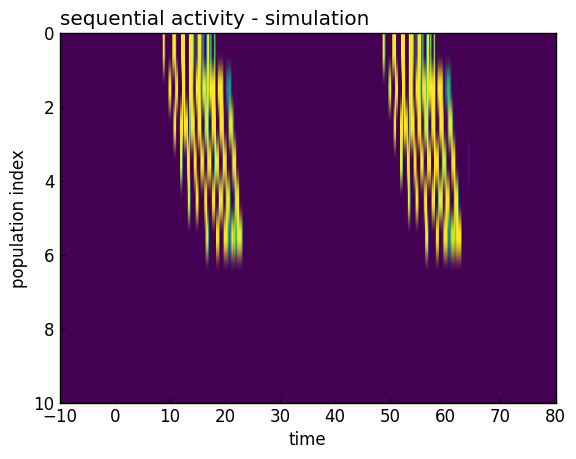

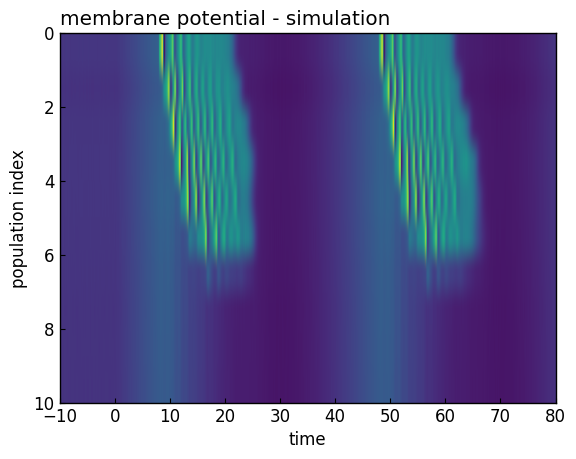

In [23]:
plt.imshow(r_plot.T, aspect='auto', cmap='viridis', extent=[t0, t1, P, 0], vmax = focus[0] + 0.1, vmin = focus[0] - 0.1)
plt.xlabel('time')
plt.ylabel('population index')
plt.title('sequential activity - simulation')
plt.show()

plt.imshow(x_plot.T, aspect='auto', cmap='viridis', extent=[t0, t1, P, 0])
plt.xlabel('time')
plt.ylabel('population index')
plt.title('membrane potential - simulation')
plt.show()



/tmp/ipykernel_1403397/3741389855.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


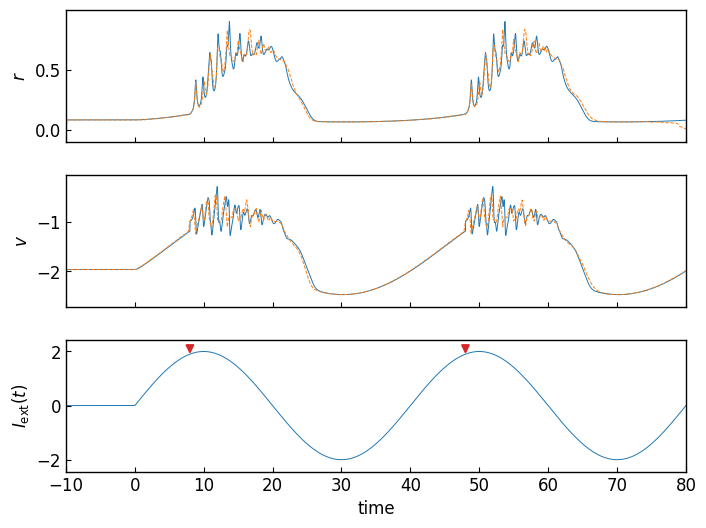

In [24]:

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, gridspec_kw={'hspace': 0.25})

axes[0].plot(t_sol, r_mean)
axes[0].plot(t_plot, np.mean(r_plot, axis = 1), ls = '--')
axes[0].set_ylabel(r'$r$')
axes[1].plot(t_sol, v_mean)
axes[1].plot(t_plot, np.mean(x_plot, axis = 1), ls = '--')
axes[1].set_ylabel(r'$v$')
axes[2].plot(t_sol, i_ext_current(t_sol))
axes[2].set_ylabel(r"$I_{\mathrm{ext}}(t)$")
axes[2].set_xlabel("time")
axes[2].set_xlim(t0, t1)
offset = 0.15 * i_amp          # y 軸方向のオフセット量（調整可）
impulse_times = np.arange(i_period * 0.2, t1 + 1e-9, i_period)
for t_imp in impulse_times:
    y_tip = i_amp * np.sin(i_omega * t_imp)   # 正弦波上の値
    axes[2].annotate("",
        xy=(t_imp, y_tip),                   # 先端
        xytext=(t_imp, y_tip + offset),      # 出発点
        arrowprops=dict(arrowstyle="-|>",    # 下向きヘッド
                        lw=1.5, color="C3",
                        shrinkA=0, shrinkB=0))
plt.tight_layout()
plt.savefig(savedir + 'ripples.pdf', bbox_inches='tight')
plt.show()


In [25]:
for name, var in [('t_sol', t_sol), ('r_sol', r_sol),
                  ('t_plot', t_plot), ('r_plot', r_plot)]:
    if torch.is_tensor(var):
        print(f'{name}: tensor, device={var.device}, dtype={var.dtype}, shape={var.shape}')
    else:
        print(f'{name}: {type(var)}, shape={np.shape(var)}')


t_sol: <class 'numpy.ndarray'>, shape=(19997,)
r_sol: <class 'numpy.ndarray'>, shape=(19997, 10)
t_plot: <class 'numpy.ndarray'>, shape=(512,)
r_plot: <class 'numpy.ndarray'>, shape=(512, 10)


Firing rate of each group (offset stack)


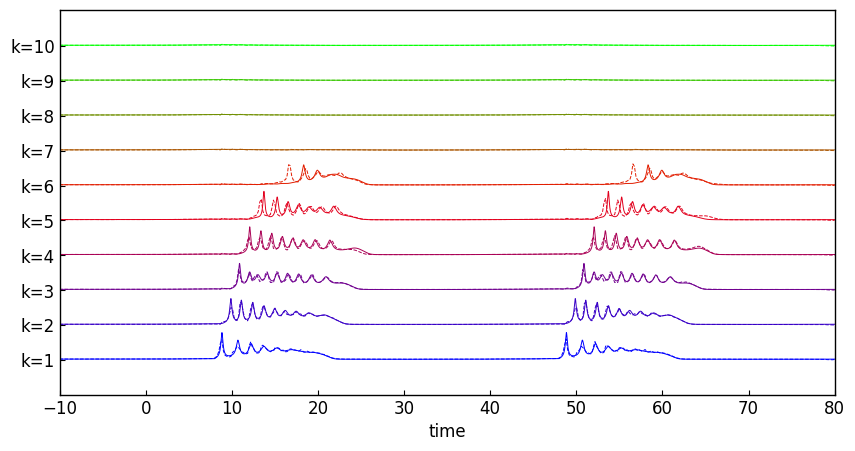

In [26]:
print('Firing rate of each group (offset stack)')
fig, ax = plt.subplots(figsize=(10, 5))
offset = r_sol.max() * 1.2          # 行間
colors = plt.cm.brg(np.linspace(0, 1, P))
for k in range(P):
    ax.plot(t_sol, r_sol[:, k] + k*offset, c = colors[k], label=f'k={k}')
    ax.plot(t_plot, r_plot[:, k] + k*offset, ls='--', c = colors[k], label=f'k={k} (simulation)')
ax.set_xlabel('time')
ax.set_yticks(offset*np.arange(P))
ax.set_yticklabels([f'k={k+1}' for k in range(P)])
ax.set_xlim(t0, t1)
plt.savefig(savedir + 'replay.pdf', bbox_inches='tight')
plt.show()


Firing rate of each group (offset stack)


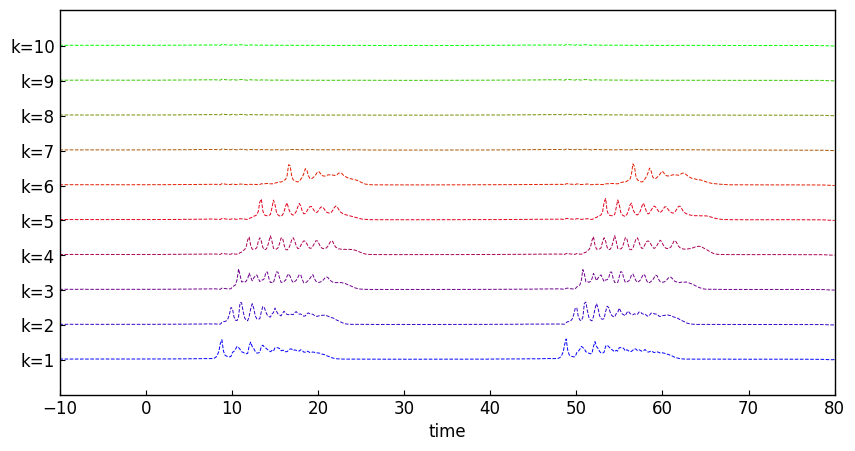

In [28]:
print('Firing rate of each group (offset stack)')
fig, ax = plt.subplots(figsize=(10, 5))
offset = r_sol.max() * 1.2          # 行間
colors = plt.cm.brg(np.linspace(0, 1, P))
for k in range(P):
    ax.plot(t_plot, r_plot[:, k] + k*offset, ls='--', c = colors[k], label=f'k={k} (simulation)')
ax.set_xlabel('time')
ax.set_yticks(offset*np.arange(P))
ax.set_yticklabels([f'k={k+1}' for k in range(P)])
ax.set_xlim(t0, t1)
plt.savefig(savedir + 'replay_simulation.pdf', bbox_inches='tight')
plt.show()


In [27]:
import pickle

# Collect variables to save
data = {
    't_sol':        t_sol,
    'y_sol':        y_sol,
    'r_sol':        r_sol,
    'v_sol':        v_sol,
    'r_mean':       r_mean,
    'v_mean':       v_mean,
    't_plot':       t_plot,
    'r_plot':       r_plot,
    'x_plot':       x_plot,
    'r_total':      r_total,
    'time_axis':    time_axis,
    'coef':         coef,
    'freqs':        freqs,
    'peak_freq':    peak_freq
}

# Save as pickle
with open(savedir + 'results.pkl', 'wb') as f:
    pickle.dump(data, f)

# Also save numeric arrays in a .npz archive
np.savez(savedir + 'results.npz', **data)